### Probabilistic Programming and Bayesian Methods for Hackers 



In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
#print('Running on PyMC3 v{}'.format(pm.__version__))

Chapter 1
======
***


### Inferring behaviour from text-message data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? (This is in fact my own text-message data. Judge my popularity as you wish.)


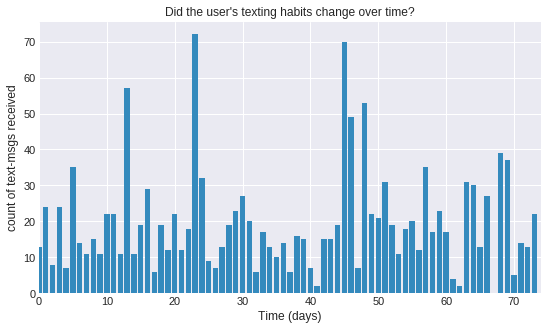

In [13]:
#
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.figure(figsize=(9,5))
plt.bar(np.arange(n_count_data), count_data, 
        color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Before we start modeling, see what you can figure out just by looking at the chart above. Would you say there was a change in behaviour during this time period? 

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

An alternative, and something I encourage the reader to try, would be to have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}


Introducing our first hammer: PyMC3
-----

PyMC3 code is easy to read. The only novel thing should be the syntax. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables.

In [14]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # count_data is the variable that holds our txt counts
    # use alpha as single parameter for both 
    alpha = 1.0/count_data.mean()
                                   
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's *stochastic variables*, so-called because they are treated by the back end as random number generators.

In [15]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

In [16]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword. 

The code below will be explained in Chapter 3, but I show it here so you can see where our results come from. One can think of it as a *learning* step. The machinery being employed is called *Markov Chain Monte Carlo* (MCMC), which I also delay explaining until Chapter 3. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called *traces* in the MCMC literature) into histograms.

In [17]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3006.59draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


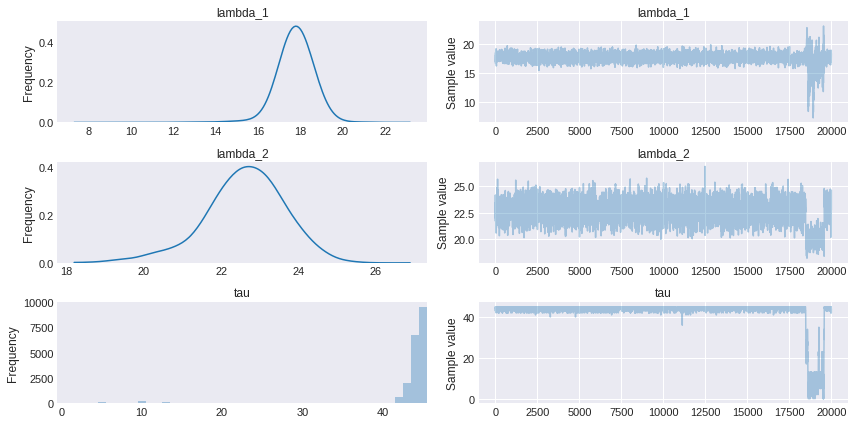

In [25]:
_ = pm.traceplot(trace,['lambda_1', 'lambda_2', 'tau'],
                combined=True)

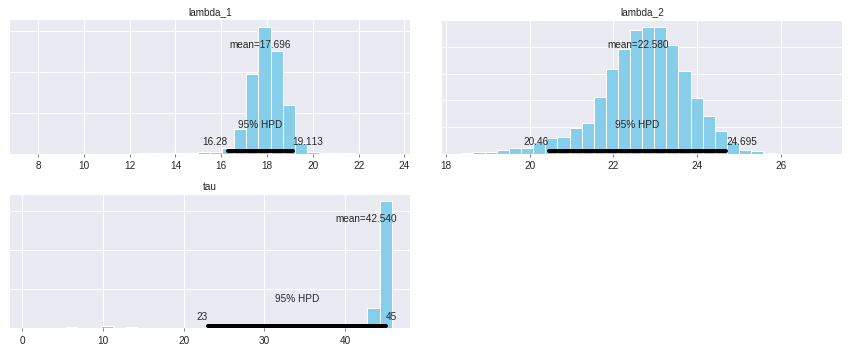

In [26]:
_ = pm.plot_posterior(trace,['lambda_1', 'lambda_2', 'tau'])

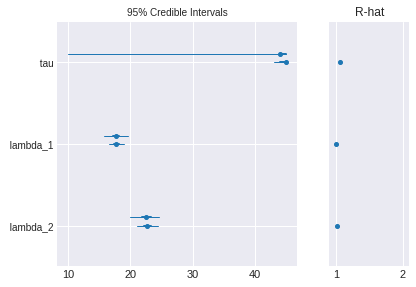

In [28]:
_ = pm.forestplot(trace)

In [43]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

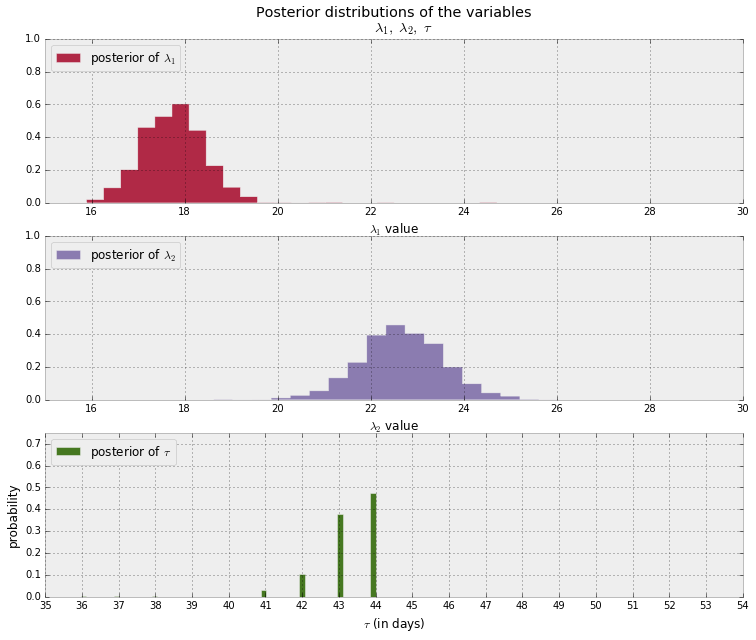

In [12]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### Why would I want samples from the posterior, anyways?


We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some amazing results. For now, let's end this chapter with one more example.

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

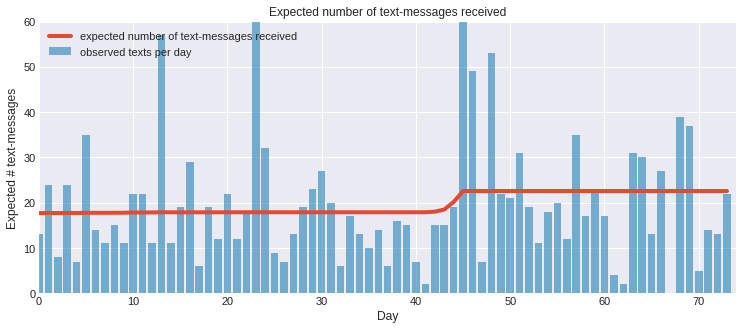

In [45]:

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

plt.figure(figsize=(12.5, 5))
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution). We can speculate what might have caused this: a cheaper text-message rate, a recent weather-to-text subscription, or perhaps a new relationship. (In fact, the 45th day corresponds to Christmas, and I moved away to Toronto the next month, leaving a girlfriend behind.)


### Determining Statistically if the Two λs Are Indeed Different?

In the text-messaging example, we visually inspected the posteriors of $λ_{1}$
and $λ_{2}$ to declare
them different. This was fair, as the general locations of the posteriors were very far apart. What if this were not true? What if the distributions partially overlapped? How can we make this decision more formal?

One way is to compute $P(λ_{1} < λ_{2} | data)$; that is, what is the probability that the true value of $λ_{1}$ is smaller than $λ_{2}$ , given the data we observed? 

If this number is close to 50%, no better than flipping a coin, then we can’t be certain they are indeed different. If this number is close to 100%, then we can be very confident that the two true values are very different. 

Using samples from the posteriors, this computation is very simple—we compute the fraction of times that a sample from the posterior of $λ_{1}$ is less than one from
$λ_{2}$ :

In [62]:
# there is virtually a 100% chance, 
# and we can be very confident the two values are different.
(lambda_1_samples < lambda_2_samples).mean()

1.0

We can ask more complicated things, too, like “`What is the probability that the values differ by at least 1? 2? 5? 10?`”

In [71]:
for d in [1,2,3,4,5,6,7,8,9,10]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print('What is the probability the difference is larger than {}? : {:.2f}%'.format(d,v*100))

What is the probability the difference is larger than 1? : 99.99%
What is the probability the difference is larger than 2? : 99.73%
What is the probability the difference is larger than 3? : 96.56%
What is the probability the difference is larger than 4? : 82.34%
What is the probability the difference is larger than 5? : 50.54%
What is the probability the difference is larger than 6? : 18.62%
What is the probability the difference is larger than 7? : 3.29%
What is the probability the difference is larger than 8? : 0.33%
What is the probability the difference is larger than 9? : 0.05%
What is the probability the difference is larger than 10? : 0.00%


##### Exercises

1\.  Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [53]:
lambda_1_samples.mean(), lambda_2_samples.mean()

(17.73334914286677, 22.743360126085395)

2\.  What is the expected percentage increase in text-message rates? `hint:` compute the mean of `lambda_1_samples/lambda_2_samples`. Note that this quantity is very different from `lambda_1_samples.mean()/lambda_2_samples.mean()`.

In [73]:
(lambda_2_samples/lambda_1_samples).mean(), lambda_2_samples.mean()/lambda_1_samples.mean()

(1.2841861844339761, 1.2825191644768297)

3\. What is the mean of $\lambda_1$ **given** that we know $\tau$ is less than 45.  That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the PyMC3 part. Just consider all instances where `tau_samples < 45`.)

In [55]:
idx = tau_samples < 45
lambda_1_samples[idx].mean()

17.737437580680005

### References


-  [1] Gelman, Andrew. N.p.. Web. 22 Jan 2013. [N is never large enough](http://andrewgelman.com/2005/07/31/n_is_never_larg).
-  [2] Norvig, Peter. 2009. [The Unreasonable Effectiveness of Data](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf).
- [3] Salvatier, J, Wiecki TV, and Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. *PeerJ Computer Science* 2:e55 <https://doi.org/10.7717/peerj-cs.55>
- [4] Jimmy Lin and Alek Kolcz. Large-Scale Machine Learning at Twitter. Proceedings of the 2012 ACM SIGMOD International Conference on Management of Data (SIGMOD 2012), pages 793-804, May 2012, Scottsdale, Arizona.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.